In [1]:
import os
import shutil
from PIL import Image
import numpy as np
import hashlib

# Original (read-only)
INPUT_TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"
INPUT_TEST_PATH  = "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test"

# Working (writable)
WORKING_DIR = "/kaggle/working/deepfake_cleaned"
TRAIN_PATH = os.path.join(WORKING_DIR, "train")
TEST_PATH  = os.path.join(WORKING_DIR, "test")

CLASSES = ["real", "fake"]
def copy_dataset(src, dst):
    """
    Copies dataset from read-only input to writable working directory.
    """
    if not os.path.exists(dst):
        shutil.copytree(src, dst)
        print(f"✔ Dataset copied from {src} to {dst}")
    else:
        print(f"✔ Dataset already exists at {dst}")

copy_dataset(INPUT_TRAIN_PATH, TRAIN_PATH)
copy_dataset(INPUT_TEST_PATH, TEST_PATH)
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")
def remove_exact_duplicates(dataset_path):
    hashes = {}
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            with open(file_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in hashes:
                os.remove(file_path)
                removed += 1
            else:
                hashes[file_hash] = file_path

    print(f"✔ Removed {removed} duplicate images from {dataset_path}")
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")

remove_corrupted_images(TRAIN_PATH)
remove_corrupted_images(TEST_PATH)

remove_exact_duplicates(TRAIN_PATH)
remove_exact_duplicates(TEST_PATH)


✔ Dataset copied from /kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train to /kaggle/working/deepfake_cleaned/train
✔ Dataset copied from /kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test to /kaggle/working/deepfake_cleaned/test
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/train
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/test
✔ Removed 3 duplicate images from /kaggle/working/deepfake_cleaned/train
✔ Removed 1 duplicate images from /kaggle/working/deepfake_cleaned/test


In [2]:
import os

TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"

classes = [
    d for d in os.listdir(TRAIN_PATH)
    if os.path.isdir(os.path.join(TRAIN_PATH, d))
]

print("Detected classes:", classes)


Detected classes: ['fake', 'real']


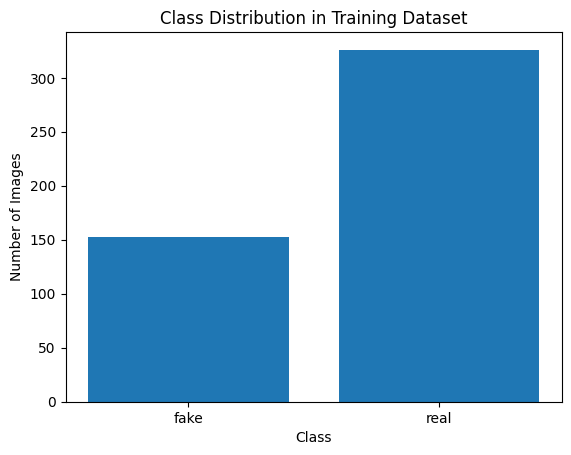

In [3]:
import matplotlib.pyplot as plt

counts = []
for label in classes:
    class_path = os.path.join(TRAIN_PATH, label)
    counts.append(len(os.listdir(class_path)))

plt.figure()
plt.bar(classes, counts)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


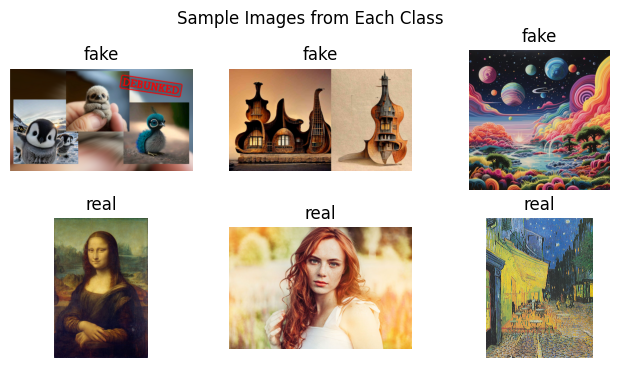

In [4]:
import random
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
idx = 1

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    samples = random.sample(os.listdir(folder), 3)

    for img_name in samples:
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(len(classes), 3, idx)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        idx += 1

plt.suptitle("Sample Images from Each Class")
plt.show()


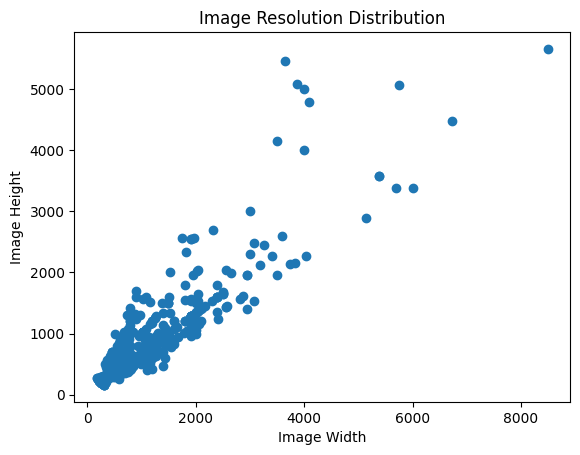

In [5]:
widths, heights = [], []

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    for img_name in os.listdir(folder):
        img = Image.open(os.path.join(folder, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure()
plt.scatter(widths, heights)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Resolution Distribution")
plt.show()


In [6]:
import os
import hashlib

def find_exact_duplicates(root_dir):
    hashes = {}
    duplicates = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(root, file)
                with open(path, "rb") as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()

                if file_hash in hashes:
                    duplicates.append((hashes[file_hash], path))
                else:
                    hashes[file_hash] = path

    return duplicates

In [7]:
DATASET_PATH = "/kaggle/working/deepfake_cleaned"
duplicates = find_exact_duplicates(DATASET_PATH)

print("Exact duplicates found:", len(duplicates))
for dup in duplicates[:5]:
    print(dup)

Exact duplicates found: 0


In [8]:
#data augmentation

import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Configuration
SOURCE_PATH = "/kaggle/working/deepfake_cleaned/train"
OUTPUT_PATH = "/kaggle/working/deepfake_augmented/train"
CLASSES = ["real", "fake"]

AUGMENT_CONFIG = {
    "real": 2,
    "fake": 5
}

def rotate_image(image, angle):
    """Rotate image by given angle"""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h))

def flip_image(image, flip_code):
    """Flip image (0=vertical, 1=horizontal, -1=both)"""
    return cv2.flip(image, flip_code)

def adjust_brightness(image, factor):
    """Adjust brightness by multiplying pixel values"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = hsv.astype(np.float32)
    hsv[:, :, 2] = hsv[:, :, 2] * factor
    hsv[:, :, 2] = np.clip(hsv[:, :, 2], 0, 255)
    hsv = hsv.astype(np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

def add_noise(image, noise_level=25):
    """Add Gaussian noise to image"""
    noise = np.random.randn(*image.shape) * noise_level
    noisy_image = image.astype(np.float32) + noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def apply_blur(image, kernel_size=5):
    """Apply Gaussian blur"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def augment_image(image, aug_type):
    """Apply specific augmentation based on type"""
    augmentations = {
        0: lambda img: flip_image(img, 1),  # Horizontal flip
        1: lambda img: rotate_image(img, np.random.randint(-15, 15)),  # Random rotation
        2: lambda img: adjust_brightness(img, np.random.uniform(0.8, 1.2)),  # Brightness
        3: lambda img: add_noise(img, np.random.randint(10, 30)),  # Noise
        4: lambda img: apply_blur(img, np.random.choice([3, 5])),  # Blur
    }
    
    # Apply random combination
    num_transforms = np.random.randint(1, 4)
    selected_transforms = np.random.choice(len(augmentations), num_transforms, replace=False)
    
    result = image.copy()
    for transform_idx in selected_transforms:
        result = augmentations[transform_idx](result)
    
    return result

def augment_dataset():
    """Augment the entire dataset"""
    
    for class_name in CLASSES:
        os.makedirs(os.path.join(OUTPUT_PATH, class_name), exist_ok=True)
    
    for class_name in CLASSES:
        source_class_path = os.path.join(SOURCE_PATH, class_name)
        output_class_path = os.path.join(OUTPUT_PATH, class_name)
        
        image_files = [f for f in os.listdir(source_class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        print(f"\nProcessing class: {class_name}")
        print(f"Found {len(image_files)} images")
        
        for img_file in tqdm(image_files, desc=f"Augmenting {class_name}"):
            img_path = os.path.join(source_class_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            # Save original
            base_name = Path(img_file).stem
            ext = Path(img_file).suffix
            cv2.imwrite(os.path.join(output_class_path, f"{base_name}_original{ext}"), img)
            
            # Create augmented versions
            for i in range(AUGMENT_CONFIG[class_name]):
                augmented_img = augment_image(img, i)
                cv2.imwrite(os.path.join(output_class_path, f"{base_name}_aug_{i}{ext}"), augmented_img)
        
        final_count = len(os.listdir(output_class_path))
        print(f"Class '{class_name}': {final_count} total images")

if __name__ == "__main__":
    print("Starting data augmentation...")
    augment_dataset()
    print("\nAugmentation complete!")
    

Starting data augmentation...

Processing class: real
Found 326 images


Augmenting real: 100%|██████████| 326/326 [01:25<00:00,  3.80it/s]


Class 'real': 978 total images

Processing class: fake
Found 150 images


Augmenting fake: 100%|██████████| 150/150 [00:54<00:00,  2.75it/s]

Class 'fake': 900 total images

Augmentation complete!


In [9]:
import os
from PIL import Image, ImageOps
import numpy as np

def letterbox_preprocessing(image_path, target_size=(294, 294)):
    """
    Preprocesses an image using the 'Letterbox' method:
    1. Pads the image to make it square without distortion.
    2. Resizes it to the target size (294x294 for Xception).
    """
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2
        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        img_padded = ImageOps.expand(img, padding, fill=(0, 0, 0))
        img_resized = img_padded.resize(target_size, Image.Resampling.LANCZOS)
        return img_resized
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_dataset_folder(root_folder, output_folder, target_size=(294, 294)):
    """
    Processes all images in a root folder containing 'real' and 'fake' subfolders.
    """
    classes = ['real', 'fake']
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for label in classes:
        input_class_path = os.path.join(root_folder, label)
        output_class_path = os.path.join(output_folder, label)
        
        if not os.path.exists(input_class_path):
            print(f"Skipping {label}: Folder not found in {root_folder}")
            continue
            
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)
            
        files = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Processing {len(files)} images in {root_folder}/{label}...")
        
        for file_name in files:
            input_path = os.path.join(input_class_path, file_name)
            output_path = os.path.join(output_class_path, file_name)
            
            processed_img = letterbox_preprocessing(input_path, target_size)
            if processed_img:
                processed_img.save(output_path)
    print(f"✔ Finished processing {root_folder} -> {output_folder}")

# Corrected paths to use the cleaned data
CLEANED_DIR = "/kaggle/working/deepfake_augmented"
CLEANED_TRAIN = os.path.join(CLEANED_DIR, "train")
CLEANED_TEST  = os.path.join(CLEANED_DIR, "test")

PREPROCESSED_DIR = "/kaggle/working/deepfake_preprocessed"
TRAIN_OUT = os.path.join(PREPROCESSED_DIR, "train")
TEST_OUT  = os.path.join(PREPROCESSED_DIR, "test")

print("Starting batch preprocessing from cleaned data...")
process_dataset_folder(CLEANED_TRAIN, TRAIN_OUT)
process_dataset_folder(CLEANED_TEST, TEST_OUT)


Starting batch preprocessing from cleaned data...
Processing 978 images in /kaggle/working/deepfake_augmented/train/real...
Processing 900 images in /kaggle/working/deepfake_augmented/train/fake...
✔ Finished processing /kaggle/working/deepfake_augmented/train -> /kaggle/working/deepfake_preprocessed/train
Skipping real: Folder not found in /kaggle/working/deepfake_augmented/test
Skipping fake: Folder not found in /kaggle/working/deepfake_augmented/test
✔ Finished processing /kaggle/working/deepfake_augmented/test -> /kaggle/working/deepfake_preprocessed/test


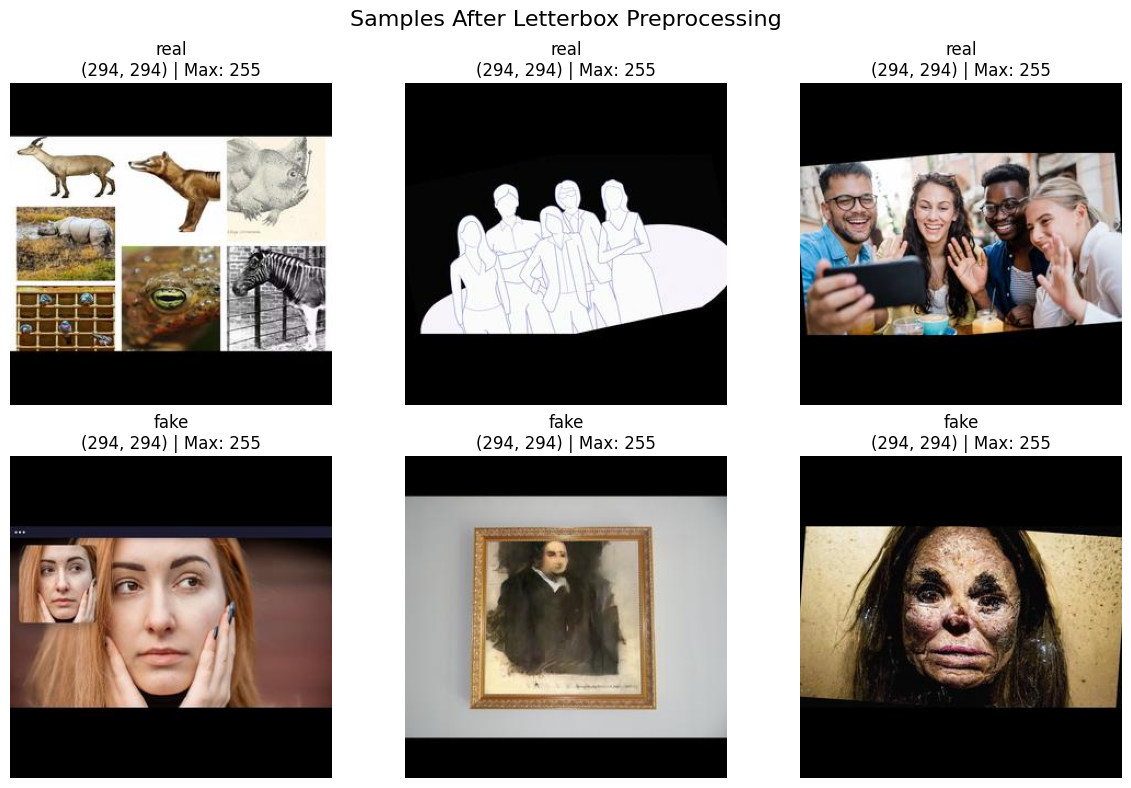

In [10]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_preprocessed_samples(base_path, num_samples=3):
    classes = ['real', 'fake']
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 8))
    
    for i, label in enumerate(classes):
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder): continue
        
        samples = random.sample(os.listdir(folder), min(num_samples, len(os.listdir(folder))))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{label}\n{img.size} | Max: {img_array.max()}")
            axes[i, j].axis('off')
            
    plt.suptitle("Samples After Letterbox Preprocessing", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the training output
visualize_preprocessed_samples(TRAIN_OUT)


Total Images Analyzed: 1878
Potential Dark Outliers: 35
Potential Blank/Low Contrast Outliers: 0


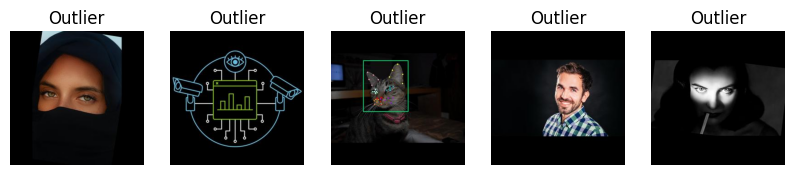

In [11]:
def analyze_outliers(base_path):
    stats = []
    paths = []
    
    for label in ['real', 'fake']:
        folder = os.path.join(base_path, label)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = np.array(Image.open(img_path)).astype(np.float32) / 255.0
            
            # Calculate mean brightness and standard deviation (contrast)
            stats.append([np.mean(img), np.std(img)])
            paths.append(img_path)
            
    stats = np.array(stats)
    means = stats[:, 0]
    stds = stats[:, 1]
    
    # Define outliers: Brightness < 0.1 (too dark) or Std < 0.05 (low contrast/blank)
    dark_outliers = np.where(means < 0.1)[0]
    blank_outliers = np.where(stds < 0.05)[0]
    
    print(f"Total Images Analyzed: {len(paths)}")
    print(f"Potential Dark Outliers: {len(dark_outliers)}")
    print(f"Potential Blank/Low Contrast Outliers: {len(blank_outliers)}")
    
    # Visualize a few outliers if they exist
    all_outliers = list(set(dark_outliers) | set(blank_outliers))
    if all_outliers:
        plt.figure(figsize=(10, 4))
        for i, idx in enumerate(all_outliers[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(Image.open(paths[idx]))
            plt.title("Outlier")
            plt.axis('off')
        plt.show()
    else:
        print("No significant statistical outliers detected!")

analyze_outliers(TRAIN_OUT)


Analyzing images for visualization...


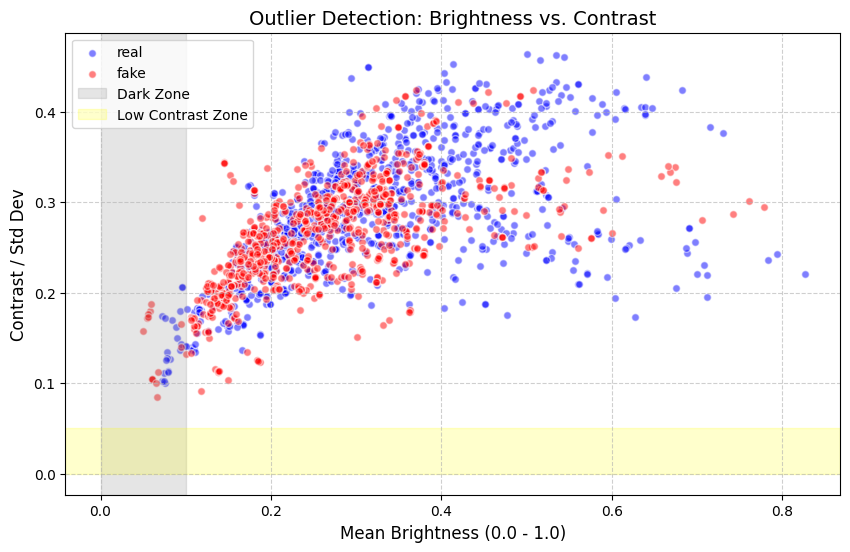

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def plot_outlier_graph(base_path):
    means = []
    stds = []
    labels = []
    
    print("Analyzing images for visualization...")
    for label in ['real', 'fake']:
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder): continue
        
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            # Load and normalize
            img = np.array(Image.open(img_path)).astype(np.float32) / 255.0
            
            means.append(np.mean(img))
            stds.append(np.std(img))
            labels.append(label)

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot Real images in Blue and Fake in Red
    for cat, color in zip(['real', 'fake'], ['blue', 'red']):
        mask = [l == cat for l in labels]
        plt.scatter(means[mask], stds[mask], alpha=0.5, label=cat, c=color, edgecolors='w', s=30)

    # Highlight the "Outlier Zones"
    plt.axvspan(0, 0.1, color='gray', alpha=0.2, label='Dark Zone') # Too dark
    plt.axhspan(0, 0.05, color='yellow', alpha=0.2, label='Low Contrast Zone') # Too flat/blank
    
    plt.title("Outlier Detection: Brightness vs. Contrast", fontsize=14)
    plt.xlabel("Mean Brightness (0.0 - 1.0)", fontsize=12)
    plt.ylabel("Contrast / Std Dev", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the visualization on your preprocessed training data
plot_outlier_graph(TRAIN_OUT)


Original training set: [782 720]
Resampled training set: [782 782]

Classification Report:
              precision    recall  f1-score   support

        real       0.91      0.90      0.91       196
        fake       0.90      0.90      0.90       180

    accuracy                           0.90       376
   macro avg       0.90      0.90      0.90       376
weighted avg       0.90      0.90      0.90       376


Confusion Matrix:
[[177  19]
 [ 18 162]]


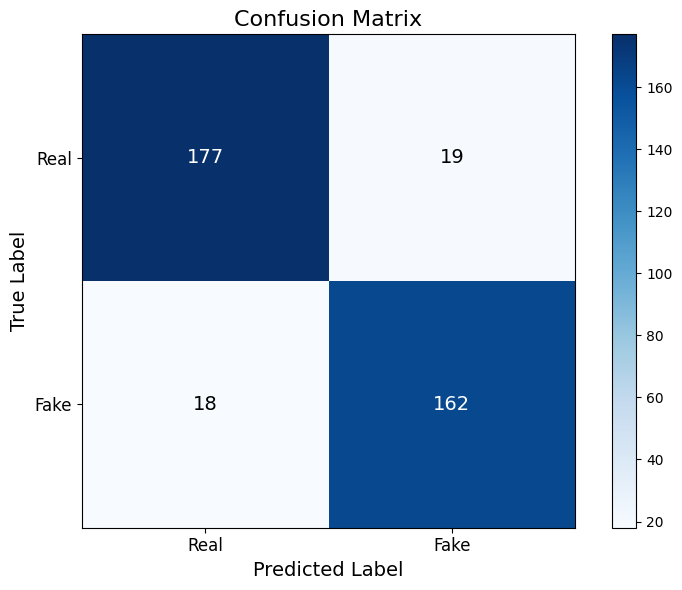

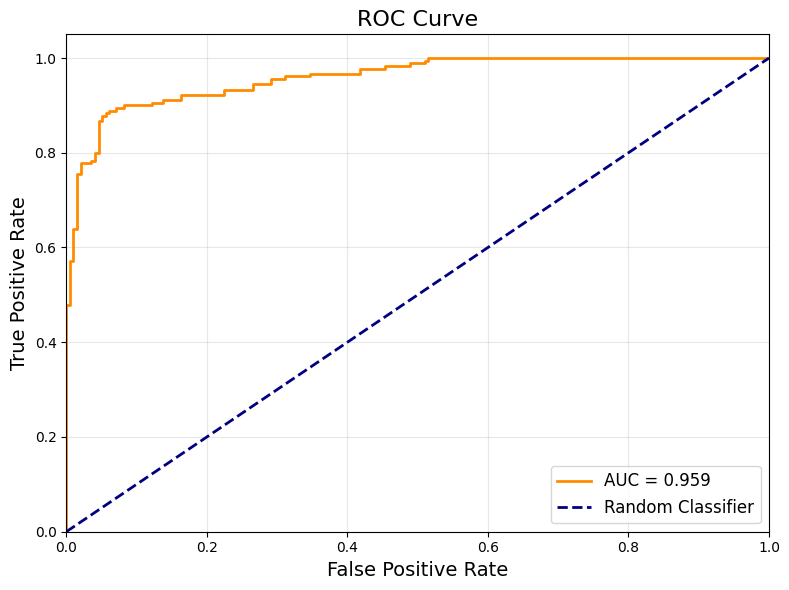

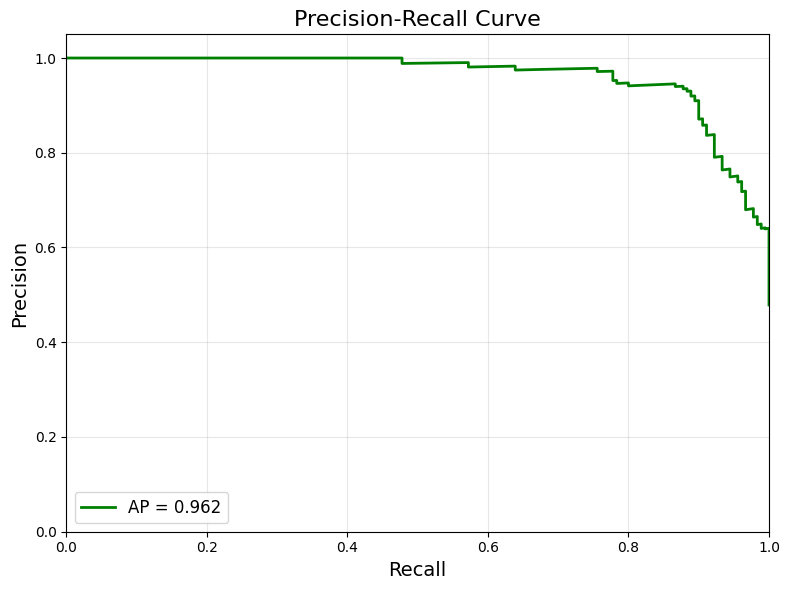

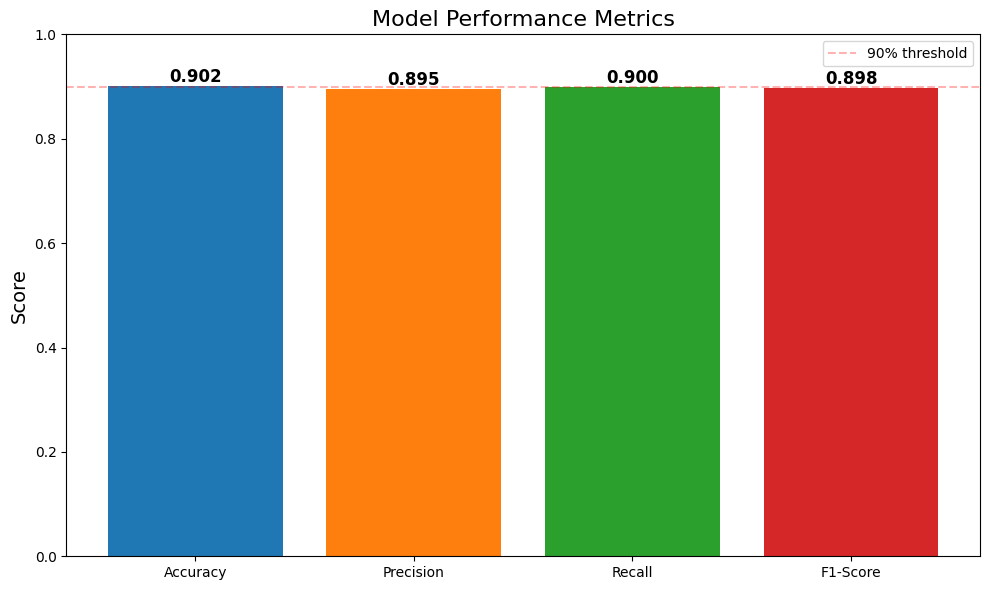


All visualizations saved successfully!

 SAVING TRAINED MODEL
✓ Model package saved as 'svm_deepfake_model.pkl'

 Package contents:
  • Trained SVM model
  • HOG configuration parameters
  • Class labels
  • Validation metrics

✓ Model-only saved as 'svm_model_only.pkl'
✓ Model summary saved as 'model_summary.txt'

 TRAINING COMPLETE!

 Validation Results:
  Accuracy:  0.9016
  Precision: 0.8950
  Recall:    0.9000
  F1-Score:  0.8975

 Saved Files:
  • svm_deepfake_model.pkl
  • svm_model_only.pkl
  • model_summary.txt
  • 4 visualization PNG files

 Ready for Testing:
  Run 'test_model.py' to evaluate on the test dataset!



In [13]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import pickle  # Added for model saving

DATASET_PATH = "/kaggle/working/deepfake_preprocessed/train"
CLASSES = ["real", "fake"]

X = []
y = []

for label in CLASSES:
    class_path = os.path.join(DATASET_PATH, label)
    class_label = 0 if label == "real" else 1
    for file in os.listdir(class_path):
        img_path = os.path.join(class_path, file)
        
        img = cv2.imread(img_path)
        img = cv2.resize(img, (294, 294))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            block_norm="L2-Hys"
        )
        X.append(features)
        y.append(class_label)

X = np.array(X)
y = np.array(y)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to balance the training data
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

print(f"Original training set: {np.bincount(y_train)}")
print(f"Resampled training set: {np.bincount(y_res)}")

# Train SVM with probability enabled
svm_model = SVC(
    kernel="rbf",
    C=7,
    gamma="scale",
    class_weight="balanced",
    probability=True  # IMPORTANT: Enable probability estimates
)

# FIX: Train on resampled data (X_res, y_res) instead of original (X_train, y_train)
svm_model.fit(X_res, y_res)

# Make predictions
y_pred = svm_model.predict(X_val)

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=CLASSES))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# 1. Confusion Matrix Heatmap
cm = confusion_matrix(y_val, y_pred)
classes = ["Real", "Fake"]

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=16)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=14)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC Curve
y_proba = svm_model.predict_proba(X_val)[:, 1]  # FIX: Use svm_model, not model
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle="--", label="Random Classifier")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f"AP = {pr_auc:.3f}")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Additional: Bar chart of metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': accuracy_score(y_val, y_pred),
    'Precision': precision_score(y_val, y_pred),
    'Recall': recall_score(y_val, y_pred),
    'F1-Score': f1_score(y_val, y_pred)
}

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1.0])
plt.ylabel('Score', fontsize=14)
plt.title('Model Performance Metrics', fontsize=16)
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.3, label='90% threshold')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("All visualizations saved successfully!")
print("="*60)

# ============================================================================
# SAVE TRAINED MODEL
# ============================================================================
print("\n" + "="*70)
print(" SAVING TRAINED MODEL")
print("="*70)

# Create model package with all necessary information
model_package = {
    'model': svm_model,
    'hog_config': {
        'orientations': 9,
        'pixels_per_cell': (8, 8),
        'cells_per_block': (2, 2),
        'block_norm': 'L2-Hys',
        'image_size': (294, 294)
    },
    'classes': CLASSES,
    'training_metrics': {
        'validation_accuracy': accuracy_score(y_val, y_pred),
        'validation_precision': precision_score(y_val, y_pred),
        'validation_recall': recall_score(y_val, y_pred),
        'validation_f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }
}

# Save the complete model package
model_filename = 'svm_deepfake_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✓ Model package saved as '{model_filename}'")
print(f"\n Package contents:")
print(f"  • Trained SVM model")
print(f"  • HOG configuration parameters")
print(f"  • Class labels")
print(f"  • Validation metrics")

# Also save just the model for simpler loading
simple_model_filename = 'svm_model_only.pkl'
with open(simple_model_filename, 'wb') as f:
    pickle.dump(svm_model, f)

print(f"\n✓ Model-only saved as '{simple_model_filename}'")

# Save model summary
summary_filename = 'model_summary.txt'
with open(summary_filename, 'w') as f:
    f.write("="*70 + "\n")
    f.write("DEEPFAKE DETECTION SVM MODEL - TRAINING SUMMARY\n")
    f.write("="*70 + "\n\n")
    
    f.write("MODEL CONFIGURATION:\n")
    f.write(f"  Algorithm:        SVM with RBF kernel\n")
    f.write(f"  C parameter:      7\n")
    f.write(f"  Gamma:            scale\n")
    f.write(f"  Class weight:     balanced\n\n")
    
    f.write("HOG FEATURE EXTRACTION:\n")
    f.write(f"  Image size:       294x294 pixels\n")
    f.write(f"  Orientations:     9\n")
    f.write(f"  Pixels per cell:  8x8\n")
    f.write(f"  Cells per block:  2x2\n")
    f.write(f"  Block norm:       L2-Hys\n\n")
    
    f.write("TRAINING DATA:\n")
    f.write(f"  Total samples:    {len(X)}\n")
    f.write(f"  Training set:     {len(X_train)} (after 80/20 split)\n")
    f.write(f"  Validation set:   {len(X_val)}\n")
    f.write(f"  Original train:   Real={np.bincount(y_train)[0]}, Fake={np.bincount(y_train)[1]}\n")
    f.write(f"  After SMOTE:      Real={np.bincount(y_res)[0]}, Fake={np.bincount(y_res)[1]}\n\n")
    
    f.write("VALIDATION PERFORMANCE:\n")
    f.write(f"  Accuracy:         {metrics['Accuracy']:.4f}\n")
    f.write(f"  Precision:        {metrics['Precision']:.4f}\n")
    f.write(f"  Recall:           {metrics['Recall']:.4f}\n")
    f.write(f"  F1-Score:         {metrics['F1-Score']:.4f}\n")
    f.write(f"  ROC AUC:          {roc_auc:.4f}\n")
    f.write(f"  PR AUC:           {pr_auc:.4f}\n\n")
    
    f.write("CONFUSION MATRIX:\n")
    f.write(f"                  Predicted\n")
    f.write(f"                  Real    Fake\n")
    f.write(f"  Actual  Real    {cm[0,0]:4d}    {cm[0,1]:4d}\n")
    f.write(f"          Fake    {cm[1,0]:4d}    {cm[1,1]:4d}\n\n")
    
    f.write("FILES SAVED:\n")
    f.write(f"  • {model_filename} (complete model package)\n")
    f.write(f"  • {simple_model_filename} (model only)\n")
    f.write(f"  • confusion_matrix.png\n")
    f.write(f"  • roc_curve.png\n")
    f.write(f"  • precision_recall_curve.png\n")
    f.write(f"  • metrics_comparison.png\n")
    f.write(f"  • {summary_filename}\n\n")
    
    f.write("NEXT STEPS:\n")
    f.write(f"  1. Run test_model.py to evaluate on the test set\n")
    f.write(f"  2. Use the model for predictions on new images\n")
    f.write("="*70 + "\n")

print(f"✓ Model summary saved as '{summary_filename}'")

print("\n" + "="*70)
print(" TRAINING COMPLETE!")
print("="*70)
print(f"\n Validation Results:")
print(f"  Accuracy:  {metrics['Accuracy']:.4f}")
print(f"  Precision: {metrics['Precision']:.4f}")
print(f"  Recall:    {metrics['Recall']:.4f}")
print(f"  F1-Score:  {metrics['F1-Score']:.4f}")

print(f"\n Saved Files:")
print(f"  • {model_filename}")
print(f"  • {simple_model_filename}")
print(f"  • {summary_filename}")
print(f"  • 4 visualization PNG files")

print(f"\n Ready for Testing:")
print(f"  Run 'test_model.py' to evaluate on the test dataset!")
print("="*70 + "\n")

 DEEPFAKE DETECTION - MODEL TESTING ON TEST SET

[STEP 1/4] Loading trained model...
----------------------------------------------------------------------
✓ Model package loaded successfully from 'svm_deepfake_model.pkl'
  Training validation accuracy: 0.9016

[STEP 2/4] Loading test data...
----------------------------------------------------------------------
  Loading real  images:  110 files ... ✓ 110 loaded
  Loading fake  images:  388 files ... ✓ 388 loaded

✓ Test set loaded:
    Total samples:      498
    Feature dimensions: 44100
    Real images:        110
    Fake images:        388

[STEP 3/4] Making predictions on test set...
----------------------------------------------------------------------
✓ Predictions completed for 498 samples

[STEP 4/4] Evaluating model performance...
----------------------------------------------------------------------

 TEST SET RESULTS

📊 OVERALL METRICS:
  Accuracy:       0.6124 (61.24%)
  Precision:      0.8019 (80.19%)
  Recall:         

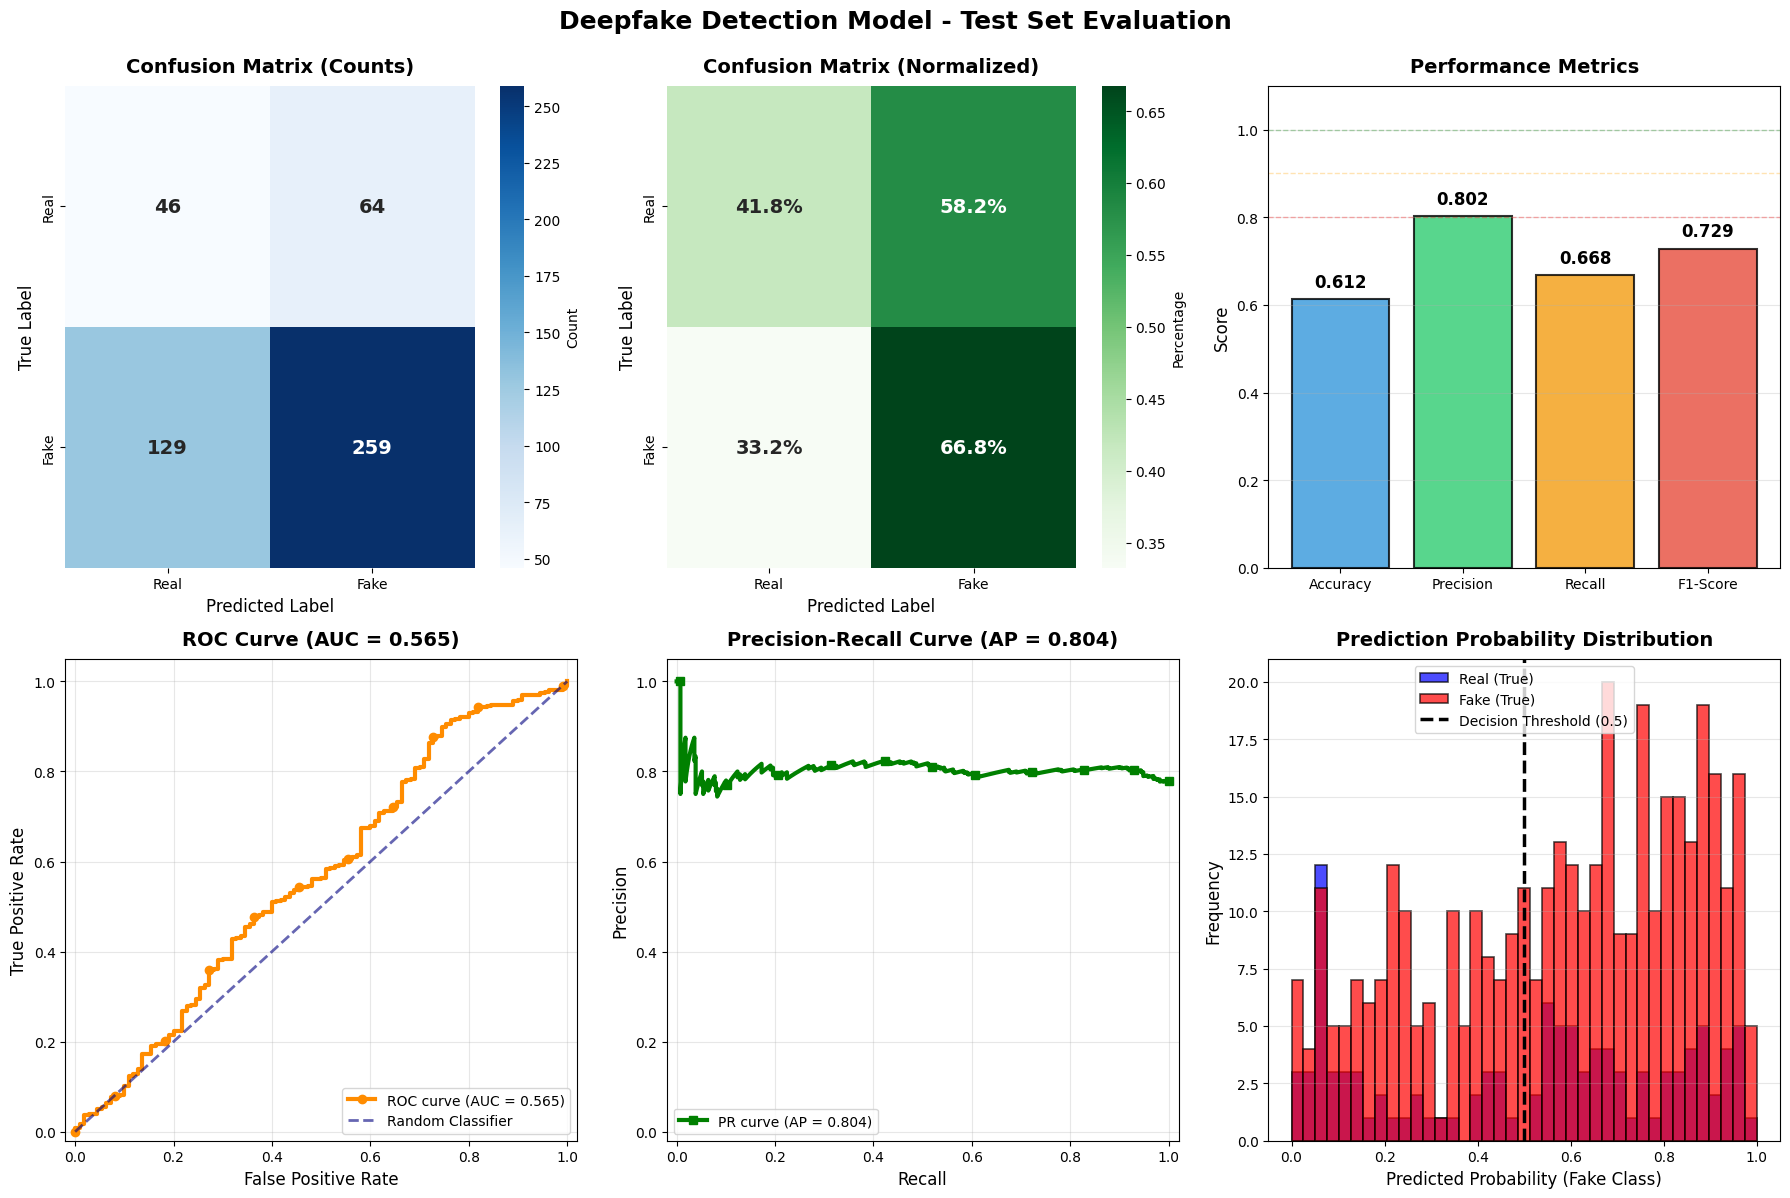


 MISCLASSIFICATION ANALYSIS

❌ Total Misclassified: 193 out of 498 (38.76%)

  False Positives:  64 (Real images incorrectly classified as Fake)
    → Impact: Users may wrongly distrust real images

  False Negatives: 129 (Fake images incorrectly classified as Real)
    → Impact: Deepfakes slip through undetected (more critical!)

----------------------------------------------------------------------
🔍 TOP 10 MOST CONFIDENT MISCLASSIFICATIONS:
----------------------------------------------------------------------

   1. 286.jpg
      True: Fake | Predicted: Real | Confidence: 99.8%

   2. 480.jpg
      True: Fake | Predicted: Real | Confidence: 99.3%

   3. 30.jpg
      True: Fake | Predicted: Real | Confidence: 99.1%

   4. 86.jpg
      True: Fake | Predicted: Real | Confidence: 98.9%

   5. 478.jpg
      True: Fake | Predicted: Real | Confidence: 98.8%

   6. 420.jpg
      True: Fake | Predicted: Real | Confidence: 98.2%

   7. 5089.jpg
      True: Real | Predicted: Fake | Confidenc

In [14]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# ============================================================================
# CONFIGURATION - MUST MATCH TRAINING
# ============================================================================
TEST_DATASET_PATH = "/kaggle/working/deepfake_cleaned/test"
CLASSES = ["real", "fake"]

# HOG parameters (MUST match training configuration)
HOG_CONFIG = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'image_size': (294, 294)
}

print("="*70)
print(" DEEPFAKE DETECTION - MODEL TESTING ON TEST SET")
print("="*70)

# ============================================================================
# STEP 1: LOAD TRAINED MODEL
# ============================================================================
print("\n[STEP 1/4] Loading trained model...")
print("-"*70)

# NOTE: Make sure you saved the model during training!
# If you haven't saved it yet, add this to your training script:
# import pickle
# with open('svm_deepfake_model.pkl', 'wb') as f:
#     pickle.dump(svm_model, f)

try:
    # Try to load saved model
    MODEL_PATH = 'svm_deepfake_model.pkl'
    with open(MODEL_PATH, 'rb') as f:
        model_package = pickle.load(f)
    
    # Extract the actual model from the package
    if isinstance(model_package, dict):
        # Model was saved as a package
        svm_model = model_package['model']
        print(f"✓ Model package loaded successfully from '{MODEL_PATH}'")
        if 'training_metrics' in model_package:
            print(f"  Training validation accuracy: {model_package['training_metrics']['validation_accuracy']:.4f}")
    else:
        # Model was saved directly
        svm_model = model_package
        print(f"✓ Model loaded successfully from '{MODEL_PATH}'")
except FileNotFoundError:
    print(f"✗ Error: Model file '{MODEL_PATH}' not found!")
    print("\nTo fix this, add the following to the END of your training script:")
    print("-"*70)
    print("import pickle")
    print("with open('svm_deepfake_model.pkl', 'wb') as f:")
    print("    pickle.dump(svm_model, f)")
    print("print('Model saved as svm_deepfake_model.pkl')")
    print("-"*70)
    print("\nFor now, assuming 'svm_model' is already in memory from training...")
    # If running in same session as training, the model should exist
    # Otherwise, you need to train first

# ============================================================================
# STEP 2: LOAD TEST DATA
# ============================================================================
print("\n[STEP 2/4] Loading test data...")
print("-"*70)

X_test = []
y_test = []
image_paths = []

for label in CLASSES:
    class_path = os.path.join(TEST_DATASET_PATH, label)
    class_label = 0 if label == "real" else 1
    
    if not os.path.exists(class_path):
        print(f"✗ Error: Path not found: {class_path}")
        continue
    
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"  Loading {label:5s} images: {len(files):4d} files", end=" ... ")
    
    loaded = 0
    for file in files:
        img_path = os.path.join(class_path, file)
        
        try:
            # Read and preprocess image
            img = cv2.imread(img_path)
            if img is None:
                continue
                
            img = cv2.resize(img, HOG_CONFIG['image_size'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Extract HOG features
            features = hog(
                img,
                orientations=HOG_CONFIG['orientations'],
                pixels_per_cell=HOG_CONFIG['pixels_per_cell'],
                cells_per_block=HOG_CONFIG['cells_per_block'],
                block_norm=HOG_CONFIG['block_norm']
            )
            
            X_test.append(features)
            y_test.append(class_label)
            image_paths.append(img_path)
            loaded += 1
        except Exception as e:
            print(f"\n    Warning: Error loading {file}: {str(e)}")
            continue
    
    print(f"✓ {loaded} loaded")

X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"\n✓ Test set loaded:")
print(f"    Total samples:      {len(X_test)}")
print(f"    Feature dimensions: {X_test.shape[1]}")
print(f"    Real images:        {np.sum(y_test==0)}")
print(f"    Fake images:        {np.sum(y_test==1)}")

# ============================================================================
# STEP 3: MAKE PREDICTIONS
# ============================================================================
print("\n[STEP 3/4] Making predictions on test set...")
print("-"*70)

y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:, 1]

print(f"✓ Predictions completed for {len(y_pred)} samples")

# ============================================================================
# STEP 4: EVALUATE PERFORMANCE
# ============================================================================
print("\n[STEP 4/4] Evaluating model performance...")
print("-"*70)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*70)
print(" TEST SET RESULTS")
print("="*70)

print(f"\n📊 OVERALL METRICS:")
print(f"  {'Accuracy:':<15} {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  {'Precision:':<15} {precision:.4f} ({precision*100:.2f}%)")
print(f"  {'Recall:':<15} {recall:.4f} ({recall*100:.2f}%)")
print(f"  {'F1-Score:':<15} {f1:.4f} ({f1*100:.2f}%)")

print("\n" + "-"*70)
print("📋 CLASSIFICATION REPORT:")
print("-"*70)
print(classification_report(y_test, y_pred, target_names=CLASSES, digits=4))

print("-"*70)
print("🔢 CONFUSION MATRIX:")
print("-"*70)
cm = confusion_matrix(y_test, y_pred)
print(f"\n                 Predicted")
print(f"                 Real    Fake")
print(f"  Actual  Real   {cm[0,0]:4d}    {cm[0,1]:4d}")
print(f"          Fake   {cm[1,0]:4d}    {cm[1,1]:4d}")

print(f"\n  True Negatives  (Real → Real): {cm[0,0]:4d}")
print(f"  False Positives (Real → Fake): {cm[0,1]:4d}")
print(f"  False Negatives (Fake → Real): {cm[1,0]:4d}")
print(f"  True Positives  (Fake → Fake): {cm[1,1]:4d}")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print(" GENERATING VISUALIZATIONS")
print("="*70)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Deepfake Detection Model - Test Set Evaluation', 
             fontsize=18, fontweight='bold', y=0.995)

# 1. Confusion Matrix (Counts)
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold', pad=10)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# 2. Normalized Confusion Matrix (Percentages)
ax2 = plt.subplot(2, 3, 2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.1%', cmap='Greens',
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Percentage'},
            annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold', pad=10)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# 3. Performance Metrics Bar Chart
ax3 = plt.subplot(2, 3, 3)
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = plt.bar(metrics_dict.keys(), metrics_dict.values(), 
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.ylim([0, 1.1])
plt.ylabel('Score', fontsize=12)
plt.title('Performance Metrics', fontsize=14, fontweight='bold', pad=10)
plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=0.9, color='orange', linestyle='--', alpha=0.3, linewidth=1)
plt.axhline(y=0.8, color='red', linestyle='--', alpha=0.3, linewidth=1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# 4. ROC Curve
ax4 = plt.subplot(2, 3, 4)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'ROC curve (AUC = {roc_auc:.3f})', marker='o', 
         markevery=len(fpr)//10, markersize=6)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier', alpha=0.6)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve (AUC = {roc_auc:.3f})', fontsize=14, fontweight='bold', pad=10)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# 5. Precision-Recall Curve
ax5 = plt.subplot(2, 3, 5)
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

plt.plot(recall_curve, precision_curve, color='green', lw=3, 
         label=f'PR curve (AP = {pr_auc:.3f})', marker='s',
         markevery=len(recall_curve)//10, markersize=6)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'Precision-Recall Curve (AP = {pr_auc:.3f})', fontsize=14, fontweight='bold', pad=10)
plt.legend(loc="lower left", fontsize=10)
plt.grid(True, alpha=0.3)

# 6. Prediction Probability Distribution
ax6 = plt.subplot(2, 3, 6)
bins = np.linspace(0, 1, 40)
plt.hist(y_proba[y_test == 0], bins=bins, alpha=0.7, label='Real (True)', 
         color='blue', edgecolor='black', linewidth=1.2)
plt.hist(y_proba[y_test == 1], bins=bins, alpha=0.7, label='Fake (True)', 
         color='red', edgecolor='black', linewidth=1.2)
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=2.5, 
            label='Decision Threshold (0.5)')
plt.xlabel('Predicted Probability (Fake Class)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Prediction Probability Distribution', fontsize=14, fontweight='bold', pad=10)
plt.legend(loc='upper center', fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('test_results_comprehensive.png', dpi=300, bbox_inches='tight')
print("✓ Saved: test_results_comprehensive.png")
plt.show()

# ============================================================================
# MISCLASSIFICATION ANALYSIS
# ============================================================================
print("\n" + "="*70)
print(" MISCLASSIFICATION ANALYSIS")
print("="*70)

# Find misclassified samples
misclassified_idx = np.where(y_pred != y_test)[0]
print(f"\n❌ Total Misclassified: {len(misclassified_idx)} out of {len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.2f}%)")

# False Positives (Real predicted as Fake)
fp_idx = np.where((y_test == 0) & (y_pred == 1))[0]
print(f"\n  False Positives: {len(fp_idx):3d} (Real images incorrectly classified as Fake)")
print(f"    → Impact: Users may wrongly distrust real images")

# False Negatives (Fake predicted as Real)
fn_idx = np.where((y_test == 1) & (y_pred == 0))[0]
print(f"\n  False Negatives: {len(fn_idx):3d} (Fake images incorrectly classified as Real)")
print(f"    → Impact: Deepfakes slip through undetected (more critical!)")

# Show worst misclassifications (highest confidence errors)
if len(misclassified_idx) > 0:
    print("\n" + "-"*70)
    print("🔍 TOP 10 MOST CONFIDENT MISCLASSIFICATIONS:")
    print("-"*70)
    
    # Sort by confidence (wrong predictions with high confidence are worst)
    confidences = []
    for idx in misclassified_idx:
        conf = y_proba[idx] if y_pred[idx] == 1 else (1 - y_proba[idx])
        confidences.append(conf)
    
    sorted_indices = np.argsort(confidences)[::-1][:10]  # Top 10
    
    for rank, i in enumerate(sorted_indices, 1):
        idx = misclassified_idx[i]
        true_label = "Real" if y_test[idx] == 0 else "Fake"
        pred_label = "Real" if y_pred[idx] == 0 else "Fake"
        confidence = confidences[i]
        filename = os.path.basename(image_paths[idx])
        
        print(f"\n  {rank:2d}. {filename}")
        print(f"      True: {true_label:4s} | Predicted: {pred_label:4s} | Confidence: {confidence:.1%}")

# ============================================================================
# SAVE DETAILED RESULTS
# ============================================================================
print("\n" + "="*70)
print(" SAVING DETAILED RESULTS")
print("="*70)

# Save text report
results_file = 'test_results_report.txt'
with open(results_file, 'w') as f:
    f.write("="*70 + "\n")
    f.write("DEEPFAKE DETECTION MODEL - TEST SET EVALUATION REPORT\n")
    f.write("="*70 + "\n\n")
    
    f.write("DATASET INFORMATION:\n")
    f.write(f"  Test samples: {len(X_test)}\n")
    f.write(f"  Real images:  {np.sum(y_test==0)}\n")
    f.write(f"  Fake images:  {np.sum(y_test==1)}\n\n")
    
    f.write("OVERALL METRICS:\n")
    f.write(f"  Accuracy:  {accuracy:.4f}\n")
    f.write(f"  Precision: {precision:.4f}\n")
    f.write(f"  Recall:    {recall:.4f}\n")
    f.write(f"  F1-Score:  {f1:.4f}\n")
    f.write(f"  ROC AUC:   {roc_auc:.4f}\n")
    f.write(f"  PR AUC:    {pr_auc:.4f}\n\n")
    
    f.write("CLASSIFICATION REPORT:\n")
    f.write(classification_report(y_test, y_pred, target_names=CLASSES))
    f.write("\n\nCONFUSION MATRIX:\n")
    f.write(f"                 Predicted\n")
    f.write(f"                 Real    Fake\n")
    f.write(f"  Actual  Real   {cm[0,0]:4d}    {cm[0,1]:4d}\n")
    f.write(f"          Fake   {cm[1,0]:4d}    {cm[1,1]:4d}\n\n")
    
    f.write(f"MISCLASSIFICATIONS:\n")
    f.write(f"  Total:            {len(misclassified_idx)}/{len(y_test)} ({len(misclassified_idx)/len(y_test)*100:.2f}%)\n")
    f.write(f"  False Positives:  {len(fp_idx)}\n")
    f.write(f"  False Negatives:  {len(fn_idx)}\n")

print(f"✓ Saved: {results_file}")

# Save predictions CSV
predictions_file = 'test_predictions.csv'
with open(predictions_file, 'w') as f:
    f.write("Filename,True_Label,Predicted_Label,Probability_Fake,Confidence,Correct\n")
    for i, (path, true, pred, prob) in enumerate(zip(image_paths, y_test, y_pred, y_proba)):
        filename = os.path.basename(path)
        true_label = "Real" if true == 0 else "Fake"
        pred_label = "Real" if pred == 0 else "Fake"
        confidence = prob if pred == 1 else (1 - prob)
        correct = "Yes" if true == pred else "No"
        f.write(f"{filename},{true_label},{pred_label},{prob:.4f},{confidence:.4f},{correct}\n")

print(f"✓ Saved: {predictions_file}")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*70)
print(" TESTING COMPLETE! ✅")
print("="*70)

print(f"\n📈 FINAL RESULTS SUMMARY:")
print(f"  Test Accuracy:      {accuracy:.2%}")
print(f"  Total Test Samples: {len(y_test)}")
print(f"  Correct:            {np.sum(y_test == y_pred)}")
print(f"  Incorrect:          {len(misclassified_idx)}")
print(f"  ROC AUC:            {roc_auc:.4f}")

print(f"\n📁 OUTPUT FILES:")
print(f"  • test_results_comprehensive.png  (Visualization)")
print(f"  • test_results_report.txt         (Detailed report)")
print(f"  • test_predictions.csv            (Per-image predictions)")

print("\n" + "="*70)